In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import *
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import IntegerType, DoubleType, BooleanType, StringType, TimestampType

from pyspark.ml.feature import VectorAssembler,StandardScaler
#from pyspark.mllib.feature import StandardScaler 

spark = SparkSession.Builder().appName('DDAM_Project_ovest').getOrCreate()
sqlCtx = SQLContext(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/13 13:22:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/13 13:23:01 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Carico il dataset già FILLATO

In [2]:
df = spark.read.options(inferSchema = True, delimiter = ',', header = True).csv('../../Datasets/West_Incidents_Cleaned.csv')

## Correlazione

In [2]:
numerical_features=['Distance_mi', 'Temperature_F', 'Wind_Chill_F', 'Humidity_perc', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']

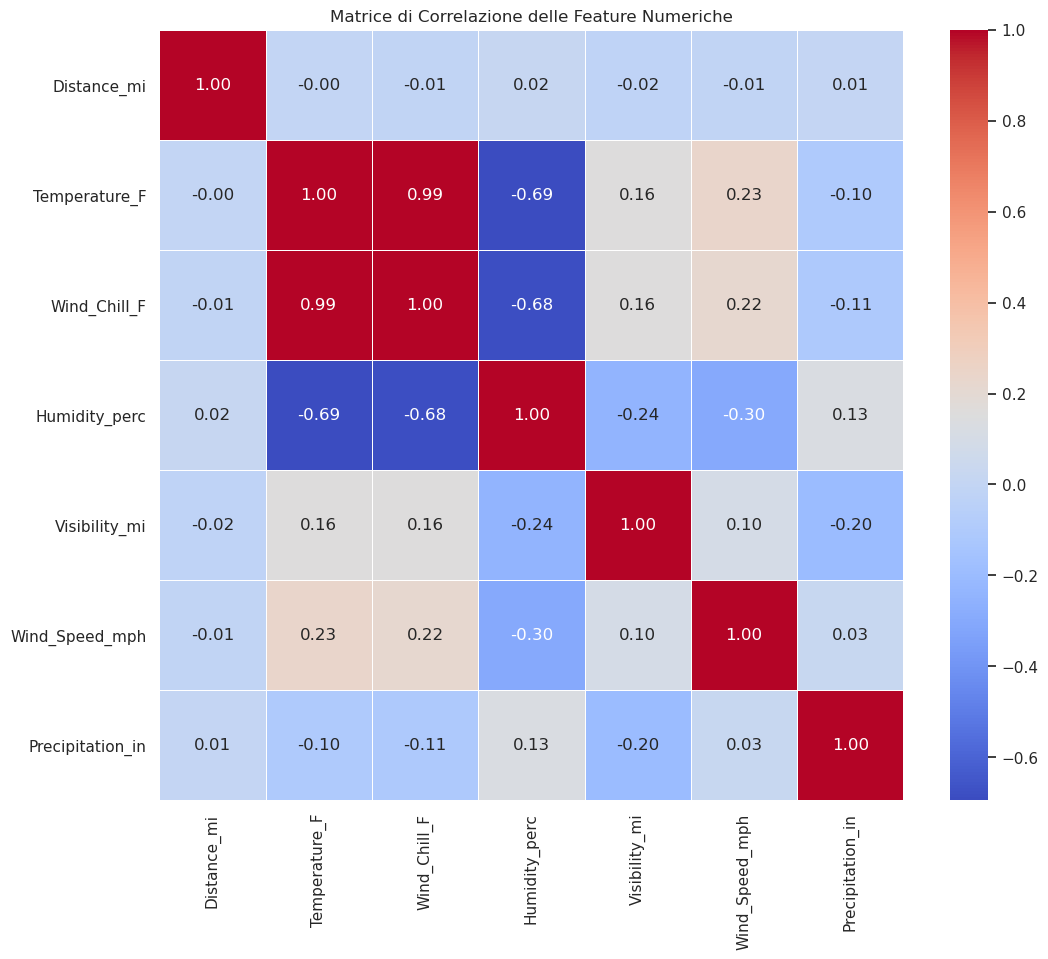

In [4]:
numerical_features=['Distance_mi', 'Temperature_F', 'Wind_Chill_F', 'Humidity_perc', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']
df_numerical = df.select(numerical_features)
df_numerical_pd = df_numerical.toPandas()
matrice_correlazione = df_numerical_pd.corr()
plt.figure(figsize=(12, 10))
sns.set(font_scale=1)
sns.heatmap(matrice_correlazione, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Matrice di Correlazione delle Feature Numeriche")
plt.show()

come già osservato dagli scatterplot, temperatura e wind_chill sono altamente correlati per cui decidiamo di droppare 'wind_chill_f'

###### Quindi DROP di 'Wind_Chill_F'

In [4]:
df=df.drop('Wind_Chill_F')

OBS: ho fatto la correlazione. in questo modo ho identificato che wind chill è quella molto correlata e l'ho quindi droppata già in questo punto 

quindi non comparirà più in tutta la parte di outliers detection

# OUTLIER DETECTION AND DELITION 

In [4]:
continuos_features=['Distance_mi', 'Temperature_F','Humidity_perc', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']

In [5]:
# SELEZIONO solo le variabili CONTINUE
df_outlier=df.select('Distance_mi', 'Temperature_F','Humidity_perc', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in')

In [6]:
assembler = VectorAssembler(
    inputCols=['Distance_mi', 'Temperature_F',  'Humidity_perc', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in'],
    outputCol='features_')

assembled_df = assembler.transform(df)


#assembled_df.select('features_').show(truncate=False)

In [7]:
inputCols='features_'

scaler = StandardScaler(inputCol = inputCols, outputCol='features_scal',withMean=True, withStd=True)# lo 'definisco' per poi usarlo
# with mean=T--> voglio che la media sia 0
#with std= rappresetnati come moltiplicazione della std (NON MI 
#RICORDO 
transformation = scaler.fit(assembled_df)
result = transformation.transform(assembled_df)

23/12/09 11:16:45 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


>>> plotting distribution for Distance_mi


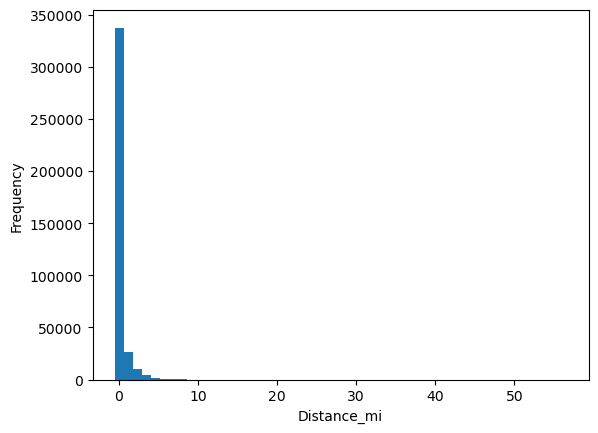

>>> plotting distribution for Temperature_F


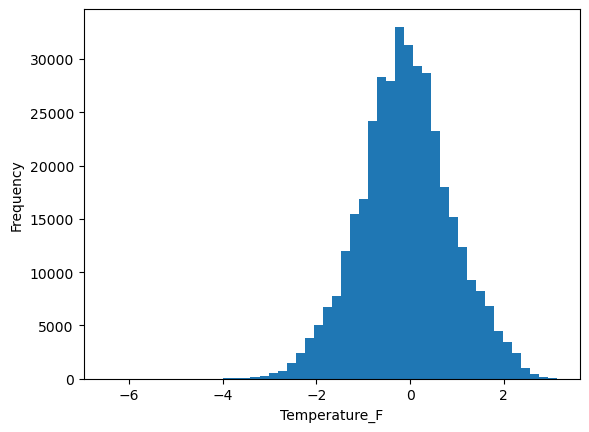

>>> plotting distribution for Humidity_perc


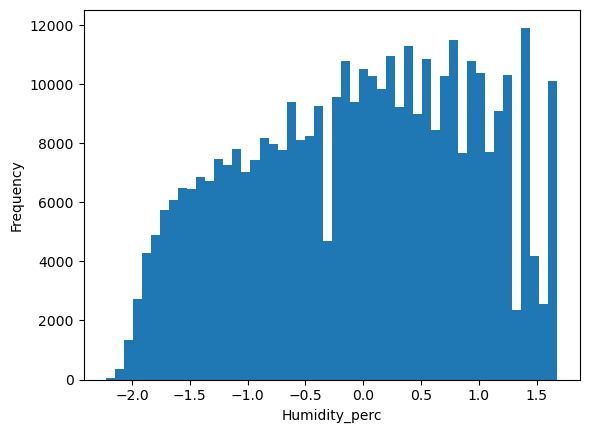

>>> plotting distribution for Visibility_mi


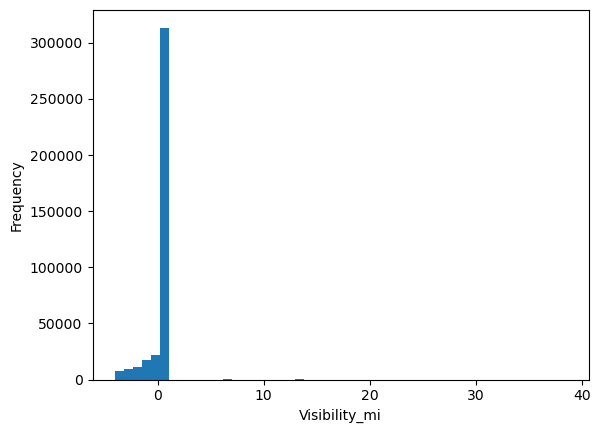

>>> plotting distribution for Wind_Speed_mph


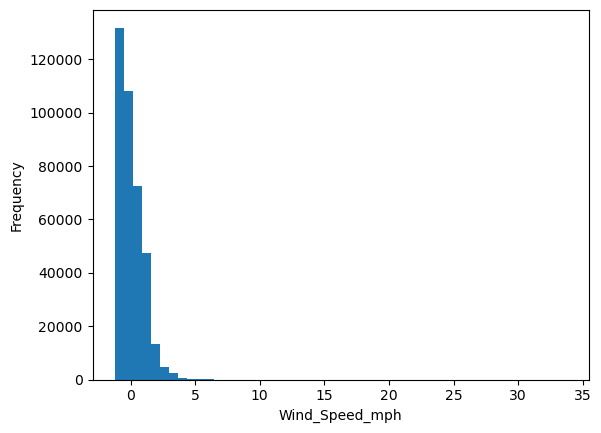

>>> plotting distribution for Precipitation_in


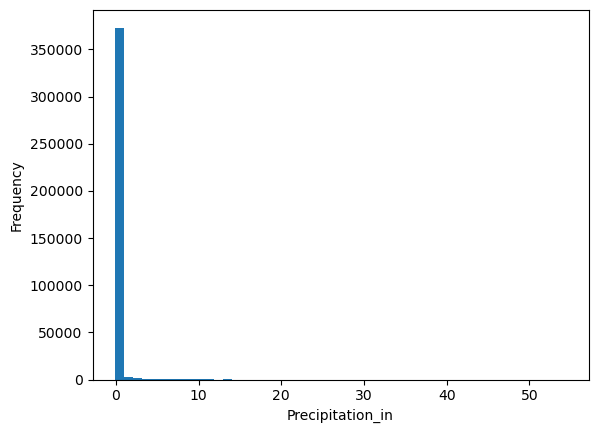

In [8]:
%matplotlib inline

result.createOrReplaceTempView("distanza") 
query = sqlCtx.sql("Select features_scal from distanza") 

xy_columns = ['Distance_mi', 'Temperature_F', 'Humidity_perc', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']
i=0
for col in xy_columns:
    
    print(f">>> plotting distribution for {col}")
    query = sqlCtx.sql('Select features_scal from distanza') 
    h = query.select('features_scal').rdd.map(lambda x: x[0][i]).histogram(50)# accortezza: prendo il primo elemento altrimenti mi fa semplicemente il flat 
    # Loading the Computed Histogram into a Pandas Dataframe for plotting
    dfh = pd.DataFrame(
        list(zip(*h)), 
        columns=['bin', 'frequency'])

    bins = dfh['bin']
    counts = dfh['frequency']

    plt.hist(bins, len(bins), weights=counts)
    plt.xlabel(f'{col}', size=10)
    plt.ylabel("Frequency", size=10)
#     plt.title("Number of songs per mode", size=10)
    plt.show()
    i+=1

### conta outliers 


In [9]:
result.createOrReplaceTempView("outliers") 
query = sqlCtx.sql("Select features_scal from outliers o")
#query.show()

i=0
xy_columns = ['Distance_mi', 'Temperature_F', 'Humidity_perc', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']
#range_=[(-2,5),(-4,3),(-4,3),(-3,2),(-10,10),(-2,5),(-2,10)]
range_=[(-2,5),(-4,3),(-3,2),(-10,10),(-2,5),(-2,10)]
i=0
for col in xy_columns: 
    h = query.select('features_scal').rdd.map(lambda x: x[0][i])
    even_numbers = h.filter(lambda x: x>range_[i][1] or x<range_[i][0])
    print(even_numbers.count(),'è la colonna',col)
    i+=1

1911 è la colonna Distance_mi


200 è la colonna Temperature_F


0 è la colonna Humidity_perc


191 è la colonna Visibility_mi


205 è la colonna Wind_Speed_mph


815 è la colonna Precipitation_in


## BOXPLOT

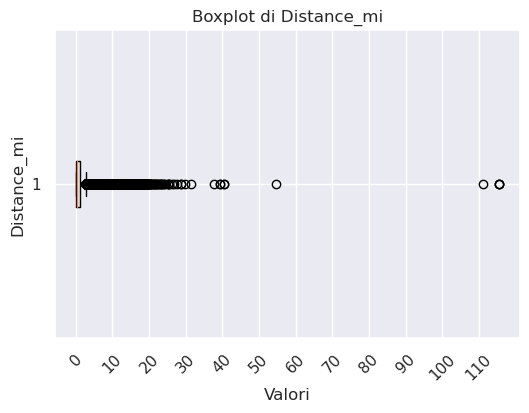

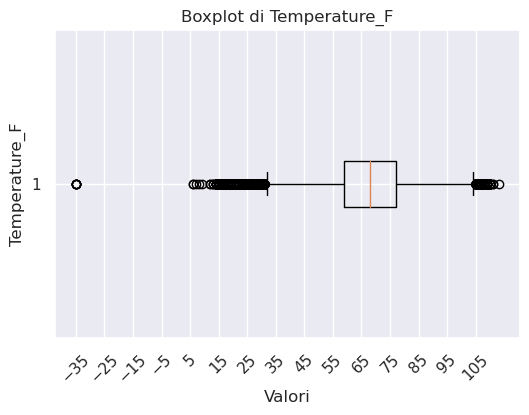

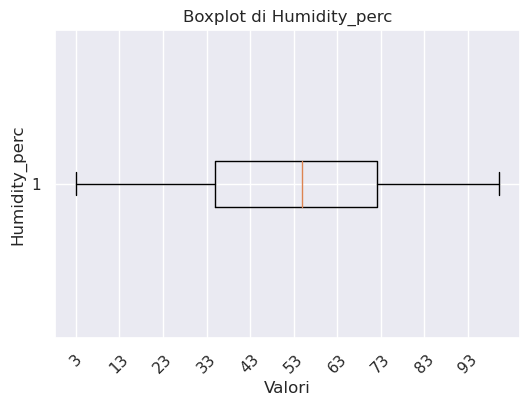

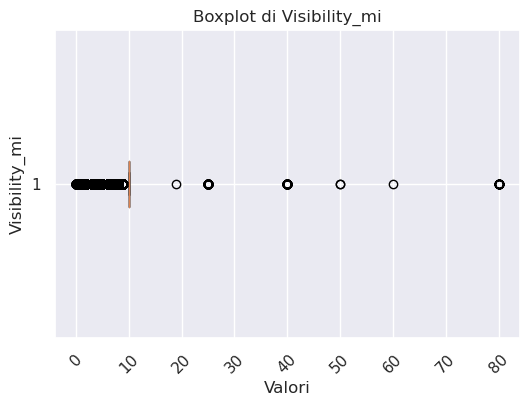

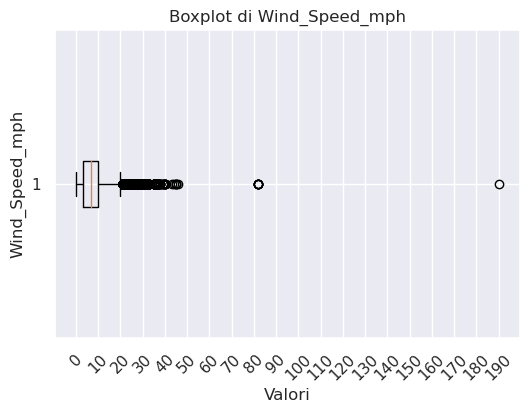

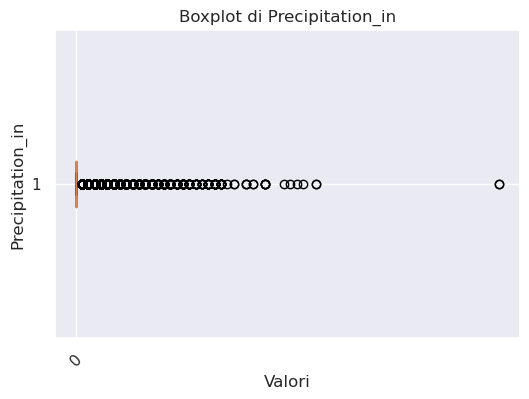

[['Numero outlier per Distance_mi 18790'], ['Numero outlier per Temperature_F 1905'], ['Numero outlier per Humidity_perc 0'], ['Numero outlier per Visibility_mi 21982'], ['Numero outlier per Wind_Speed_mph 2725'], ['Numero outlier per Precipitation_in 2491']]


In [8]:
cols=['Distance_mi', 'Temperature_F', 'Humidity_perc', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']
df.createOrReplaceTempView("df")
outliers_list=[]
for col in cols: 
    df_filtered = df.filter(df[col].isNotNull())
    percentiles = df_filtered.approxQuantile(col, [0.25, 0.5, 0.75], 0.01)
    Q1, median, Q3 = percentiles
    IQR=Q3-Q1
    W1=Q1-1.5*IQR
    W3=Q3+1.5*IQR
    query=""" SELECT """+ col + """ FROM df WHERE """ + col + """<""" + str(W1) +""" OR """+ col + """>""" + str(W3)
    outliers=sqlCtx.sql(query)
    numero_outliers=outliers.count()
    outliers_list.append(['Numero outlier per '+ col+' '+str(numero_outliers)])
    min_Query=""" SELECT MIN("""+col+""") AS Min FROM df """
    min_=sqlCtx.sql(min_Query)
    min_=min_.select('Min').rdd.flatMap(lambda x: x).collect()[0]
    max_Query=""" SELECT MAX("""+col+""") AS Max FROM df """
    max_=sqlCtx.sql(max_Query)
    max_=max_.select('Max').rdd.flatMap(lambda x: x).collect()[0]
    plt.figure(figsize=(6, 4))
    plt.boxplot([df_filtered.select(col).rdd.flatMap(lambda x: x).collect()], vert=False)
    plt.title('Boxplot di {}'.format(col))
    plt.xlabel('Valori')
    plt.ylabel('{}'.format(col))
    #plt.xticks([W1, Q1, median, Q3,W3], ['W1', 'Q1', 'Median', 'Q3', 'W3'])
    plt.xticks(range(int(min_),int(max_)+1,10), rotation=45)
    plt.show()
print(outliers_list)

# CLUSTERING

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SQLContext, SparkSession, Row
from pyspark.sql.functions import *
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import IntegerType, DoubleType, BooleanType, StringType, TimestampType
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler
import plotly.express as px

from pyspark.mllib.clustering import BisectingKMeans as BM
from pyspark.mllib.clustering import BisectingKMeansModel
from pyspark.ml.clustering import BisectingKMeans

In [16]:
!pip install kneed
!pip install yellowbrick
from kneed import KneeLocator
import matplotlib.pyplot as plt

  Using cached yellowbrick-1.5-py3-none-any.whl (282 kB)


In [6]:
df_cluster=df
df_cluster.count()

381437

Row(_c0=0, Severity=2, Start_Time=datetime.datetime(2022, 5, 23, 5, 0), Start_Lat=36.980083, Start_Lng=-120.04043, 
    Distance_mi=0.158, 
    County='Madera', State='CA', 
    Temperature_F=56.0, Humidity_perc=69.0, Visibility_mi=10.0,
    Wind_Direction=56.0, 
    Wind_Speed_mph=5.0, Precipitation_in=0.0,
    Amenity=False, Bump=False, Crossing=False, 
    Give_Way=False, Junction=False, No_Exit=False, Railway=False, Roundabout=False, Station=False, Stop=False,
    Traffic_Calming=False, Traffic_Signal=False, 
    month=5, day_of_the_week='Monday', hour=5, season='Spring', 
    Working_Weekend='WorkingDay',
    City='Madera', Astronomical_Twilight='Day', Weather_Condition='Normal')]

## 1_ TUTTE LE CONTINUE

In [9]:
col = ['Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']# TUTTE

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster)

scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")

output_dataset = scaler.fit(output_dataset).transform(output_dataset)

#clusteringData.show(truncate=False)

In [ ]:
clusteringData = output_dataset.select("features_scaled")

************************************************



Results for K = 2
Silhouette with squared euclidean distance: 0.7171
SSE (Sum of Squared Errors): 10130.898005558867
************************************************



Results for K = 3
Silhouette with squared euclidean distance: 0.6349
SSE (Sum of Squared Errors): 6093.6360954454685
************************************************



Results for K = 4
Silhouette with squared euclidean distance: 0.5543
SSE (Sum of Squared Errors): 4710.582195753451
************************************************



Results for K = 5
Silhouette with squared euclidean distance: 0.4928
SSE (Sum of Squared Errors): 4185.840585614106
************************************************



Results for K = 6
Silhouette with squared euclidean distance: 0.4703
SSE (Sum of Squared Errors): 3600.521250180146
************************************************



Results for K = 7
Silhouette with squared euclidean distance: 0.4542
SSE (Sum of Squared Errors): 3277.837303953711
************************************************



Results for K = 8
Silhouette with squared euclidean distance: 0.4327
SSE (Sum of Squared Errors): 3037.2271251385705
************************************************



Results for K = 9
Silhouette with squared euclidean distance: 0.4413
SSE (Sum of Squared Errors): 2780.1348187075387


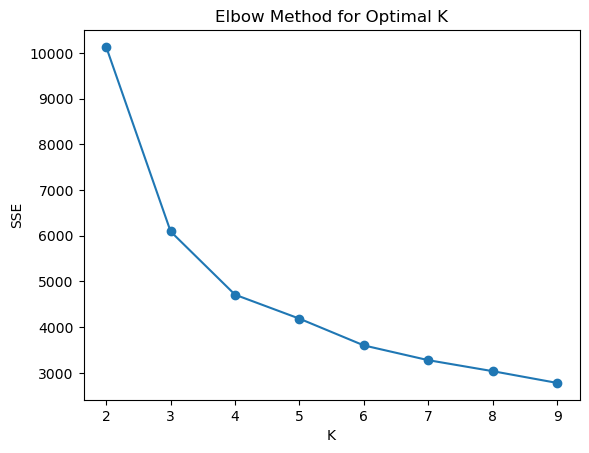

Elbow detected at K = 4


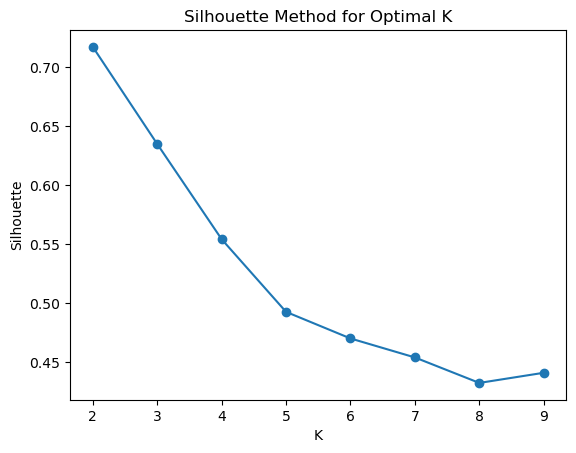

In [17]:
sse_values = []
silhouette_values = []
for k in range(2,10):

    print('************************************************\n')
    kmeans = KMeans(featuresCol="features_scaled", k=k)
    model = kmeans.fit(clusteringData)
    evaluator = ClusteringEvaluator(featuresCol="features_scaled")
    predictions = model.transform(clusteringData)
    silhouette = evaluator.evaluate(predictions)
    sse = model.summary.trainingCost
    
    print(f"Results for K = {k}")
    print(f"Silhouette with squared euclidean distance: {silhouette:.4f}")
    print(f"SSE (Sum of Squared Errors): {sse}")
    sse_values.append(sse)
    silhouette_values.append(silhouette)

# Plot SSE per valutare l'elbow
plt.figure()
plt.plot(range(2, 10), sse_values, marker='o')
plt.xlabel("K")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal K")
plt.show()

# Trova l'elbow con KneeLocator
kl = KneeLocator(range(2, 10), sse_values, curve="convex", direction="decreasing")
print(f"Elbow detected at K = {kl.elbow}")

plt.figure()
plt.plot(range(2, 10), silhouette_values, marker='o')
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.title("Silhouette Method for Optimal K")
plt.show()

Facendo un tradeoff tra silhouette e SSE si puo dire che il k ideale per i nostri dati è forse 6



### SEVERITY

In [ ]:
clusteringData = output_dataset.select("features_scaled", "Severity")# SEVERITY

Silhouette  = 0.5543142747915418

SSE  = 4710.582195753453


Contingency Table:


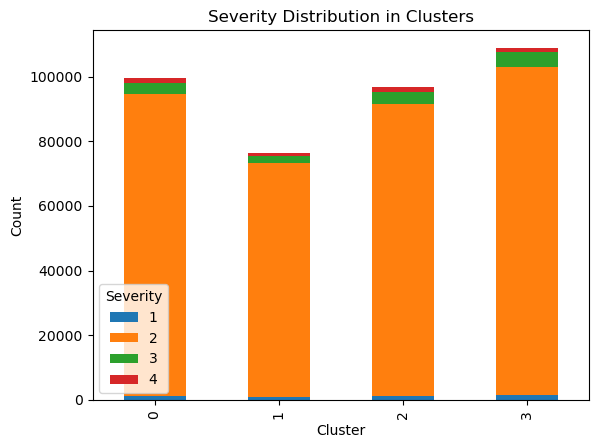

In [23]:
kmeans = KMeans(featuresCol="features_scaled").setK(4) #TUTTE LE CONTINUE !!!
model = kmeans.fit(clusteringData)
predictions = model.transform(clusteringData)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Severity').count().toPandas() # Weather Condiotion!!!
pivot_table = contingency_table.pivot(index='prediction', columns='Severity', values='count')

print("Contingency Table:")
# print(pivot_table)

pivot_table.plot(kind='bar', stacked=True, title='Severity Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

### Weather condition

In [27]:
clusteringData = output_dataset.select("features_scaled", "Weather_Condition")

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


Silhouette  = 0.5543142747915418

SSE  = 4710.582195753452


Contingency Table:
Weather_Condition   Cloudy   Foggy   Normal     Rain    Snow
prediction                                                  
0                  37422.0  8961.0  36991.0  12907.0  3241.0
1                   5272.0  1065.0  69957.0     42.0     NaN
2                  12019.0  1376.0  82969.0    303.0    12.0
3                  31181.0  2677.0  73466.0   1437.0   139.0


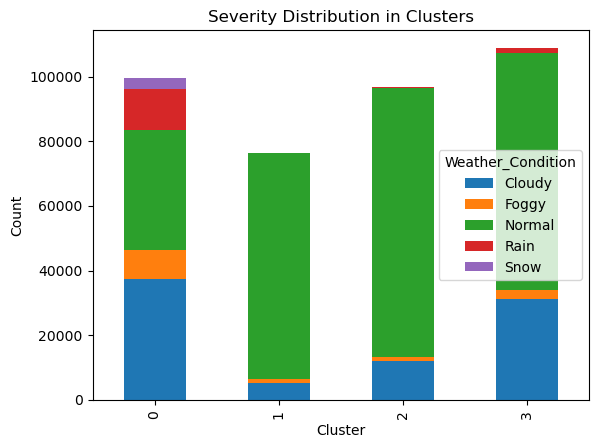

In [28]:
kmeans = KMeans(featuresCol="features_scaled").setK(4)
model = kmeans.fit(clusteringData)
predictions = model.transform(clusteringData)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Weather_Condition').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Weather_Condition', values='count')

print("Contingency Table:")
print(pivot_table)

pivot_table.plot(kind='bar', stacked=True, title='Severity Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

### Working_Weekend

In [12]:
clusteringData = output_dataset.select("features_scaled", "Working_Weekend")

Silhouette  = 0.5563771380690967

SSE  = 4695.547353453344


Contingency Table:
Working_Weekend  Weekend  WorkingDay
prediction                          
0                  25415       82624
1                  18054       65719
2                  23454       79386
3                  20793       65992


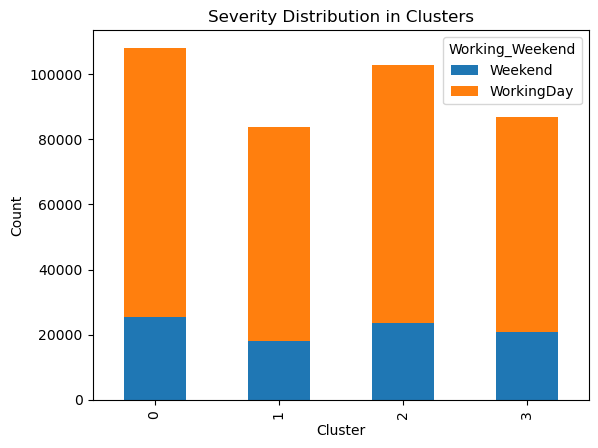

In [13]:
kmeans = KMeans(featuresCol="features_scaled").setK(4)
model = kmeans.fit(clusteringData)
predictions = model.transform(clusteringData)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Working_Weekend').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Working_Weekend', values='count')

print("Contingency Table:")
print(pivot_table)

pivot_table.plot(kind='bar', stacked=True, title='Severity Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

### season

In [14]:
clusteringData = output_dataset.select("features_scaled", "season")

Silhouette  = 0.5563771380690967

SSE  = 4695.547353453344


Contingency Table:
season      Autumn  Spring  Summer  Winter
prediction                                
0            23585   30094   29333   25027
1            15588   24453   25357   18375
2            22335   30320   28318   21867
3            19172   17459   12033   38121


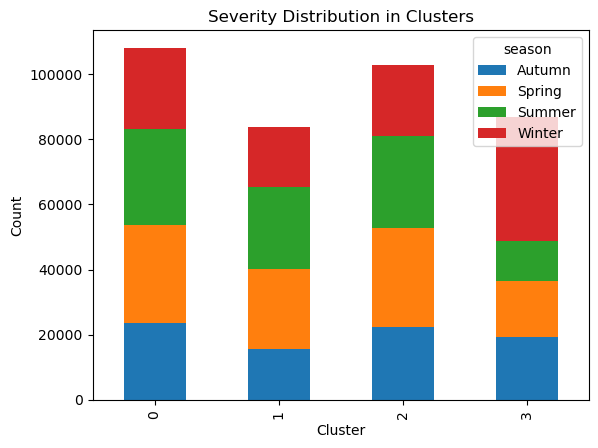

In [15]:
kmeans = KMeans(featuresCol="features_scaled").setK(4)
model = kmeans.fit(clusteringData)
predictions = model.transform(clusteringData)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'season').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='season', values='count')

print("Contingency Table:")
print(pivot_table)

pivot_table.plot(kind='bar', stacked=True, title='Severity Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

### day_of_the_week

In [17]:
clusteringData = output_dataset.select("features_scaled", "day_of_the_week")

Silhouette  = 0.5563771380690967

SSE  = 4695.547353453344


Contingency Table:
day_of_the_week  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  \
prediction                                                             
0                 17153   15065     14040   11375     16678    16963   
1                 16957   10070     10273    7781     13340    12007   
2                 18601   13624     13100   10354     15898    14709   
3                 12972   12742     11603    9190     13341    14730   

day_of_the_week  Wednesday  
prediction                  
0                    16765  
1                    13345  
2                    16554  
3                    12207  


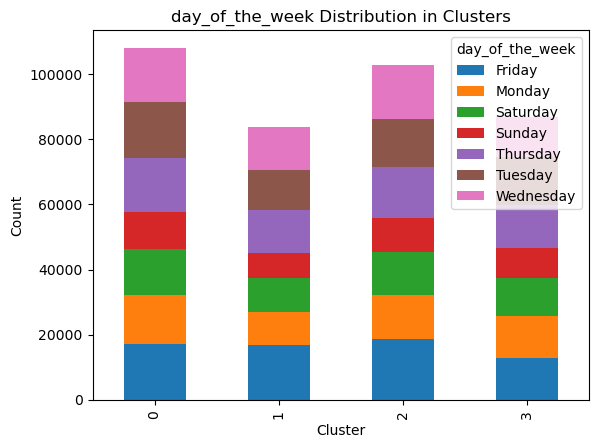

In [18]:
kmeans = KMeans(featuresCol="features_scaled").setK(4)
model = kmeans.fit(clusteringData)
predictions = model.transform(clusteringData)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'day_of_the_week').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='day_of_the_week', values='count')

print("Contingency Table:")
print(pivot_table)

pivot_table.plot(kind='bar', stacked=True, title='day_of_the_week Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

### hour

In [20]:
clusteringData = output_dataset.select("features_scaled", "hour")

Silhouette  = 0.5563771380690967

SSE  = 4695.547353453344


Contingency Table:
hour          0     1     2     3     4     5     6      7     8     9   ...  \
prediction                                                               ...   
0           2112  1941  1875  1613  1804  3628  5315   8218  8263  5543  ...   
1            419   311   332   224   270   519   647   1169  1695  2258  ...   
2           1003   800   828   683   879  1781  2565   3623  3792  3906  ...   
3           2822  2433  2760  2418  3171  6733  9889  10316  6922  3285  ...   

hour           14     15    16    17    18    19    20    21    22    23  
prediction                                                                
0            5414   5785  6252  7368  6475  4531  3833  3727  3392  2810  
1           11536  11528  9819  8402  4962  2774  1811  1404   930   636  
2           10707  10429  9376  8723  5491  3280  2619  2323  1682  1372  
3            1603   1891  2131  3323  3363  3158  3247  3485  3244  3012  

[4 rows x 24 columns]


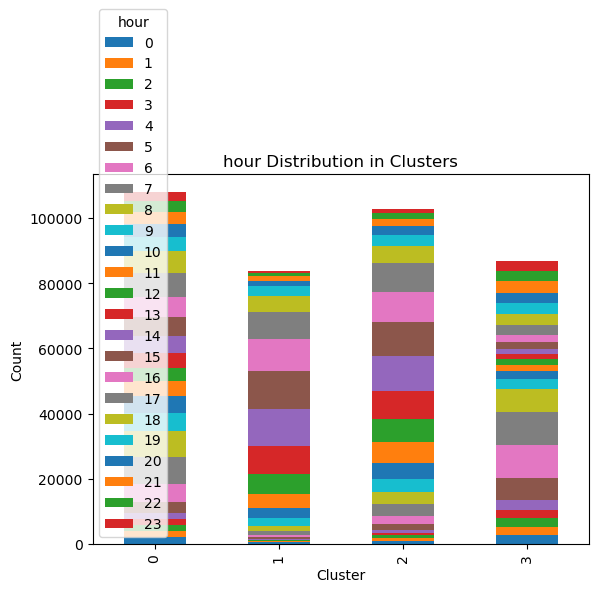

In [21]:
kmeans = KMeans(featuresCol="features_scaled").setK(4)
model = kmeans.fit(clusteringData)
predictions = model.transform(clusteringData)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'hour').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='hour', values='count')

print("Contingency Table:")
print(pivot_table)

pivot_table.plot(kind='bar', stacked=True, title='hour Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

### Astronomical_Twilight

In [22]:
clusteringData = output_dataset.select("features_scaled", "Astronomical_Twilight")

Silhouette  = 0.5563771380690967

SSE  = 4695.547353453343


Contingency Table:
Astronomical_Twilight    Day  Night
prediction                         
0                      85282  22757
1                      78729   5044
2                      91772  11068
3                      57273  29512


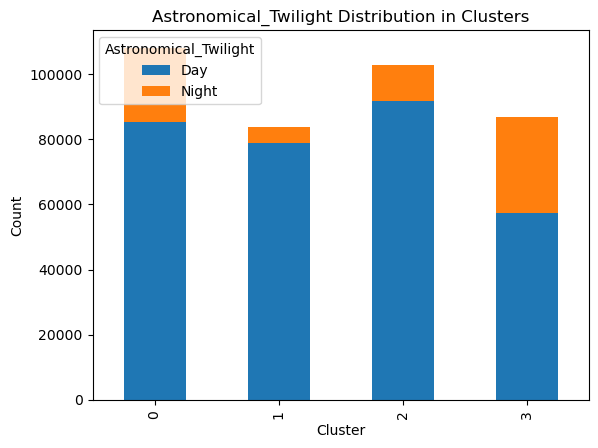

In [23]:
kmeans = KMeans(featuresCol="features_scaled").setK(4)
model = kmeans.fit(clusteringData)
predictions = model.transform(clusteringData)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Astronomical_Twilight').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Astronomical_Twilight', values='count')

print("Contingency Table:")
print(pivot_table)

pivot_table.plot(kind='bar', stacked=True, title='Astronomical_Twilight Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

### State

In [24]:
clusteringData = output_dataset.select("features_scaled", "State")

Silhouette  = 0.5563771380690967

SSE  = 4695.547353453344


Contingency Table:
State          CA     OR    WA
prediction                    
0           97273   6644  4122
1           80710   2608   455
2           94895   4997  2948
3           67997  12211  6577


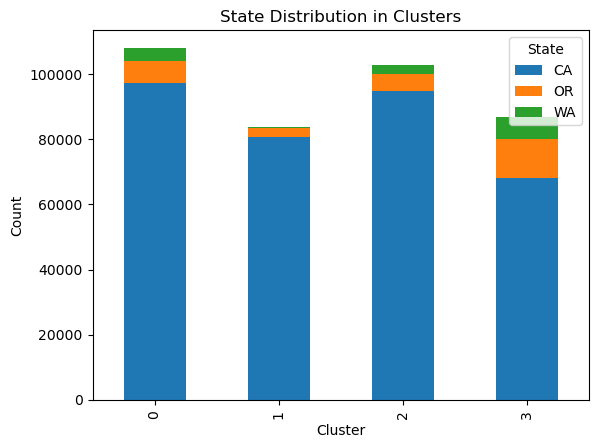

In [25]:
kmeans = KMeans(featuresCol="features_scaled").setK(4)
model = kmeans.fit(clusteringData)
predictions = model.transform(clusteringData)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'State').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='State', values='count')

print("Contingency Table:")
print(pivot_table)

pivot_table.plot(kind='bar', stacked=True, title='State Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

## 2 a_ Riiduco Drasticamente gli attributi continui rispetto ai quali sto facendo i cluster.

nel mio caso 'essendo humidity e temp correlate faccio prove_

In [26]:
#col = ['Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']
col = ['Temperature_F','Precipitation_in']# solo 2

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster)

scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")

output_dataset = scaler.fit(output_dataset).transform(output_dataset)

In [ ]:
clusteringData = output_dataset.select("features_scaled")

************************************************



Results for K = 2
Silhouette with squared euclidean distance: 0.7171
SSE (Sum of Squared Errors): 10130.896354715926
************************************************



Results for K = 3
Silhouette with squared euclidean distance: 0.6347
SSE (Sum of Squared Errors): 6093.731905995095
************************************************



Results for K = 4
Silhouette with squared euclidean distance: 0.5564
SSE (Sum of Squared Errors): 4695.547353453343
************************************************



Results for K = 5
Silhouette with squared euclidean distance: 0.4926
SSE (Sum of Squared Errors): 4002.584081767088
************************************************



Results for K = 6
Silhouette with squared euclidean distance: 0.4886
SSE (Sum of Squared Errors): 3628.3609544783662
************************************************



Results for K = 7
Silhouette with squared euclidean distance: 0.4625
SSE (Sum of Squared Errors): 3309.5157308110925
************************************************



Results for K = 8
Silhouette with squared euclidean distance: 0.4431
SSE (Sum of Squared Errors): 2940.7351089923914
************************************************



Results for K = 9
Silhouette with squared euclidean distance: 0.4509
SSE (Sum of Squared Errors): 2918.373190062795
************************************************



Results for K = 10
Silhouette with squared euclidean distance: 0.4150
SSE (Sum of Squared Errors): 2765.80366971751
************************************************



Results for K = 11
Silhouette with squared euclidean distance: 0.4467
SSE (Sum of Squared Errors): 2443.3725854954905
************************************************



Results for K = 12
Silhouette with squared euclidean distance: 0.4393
SSE (Sum of Squared Errors): 2150.281732914153
************************************************



Results for K = 13
Silhouette with squared euclidean distance: 0.4376
SSE (Sum of Squared Errors): 2100.0347243821298
************************************************



Results for K = 14
Silhouette with squared euclidean distance: 0.4252
SSE (Sum of Squared Errors): 1950.8536128675016


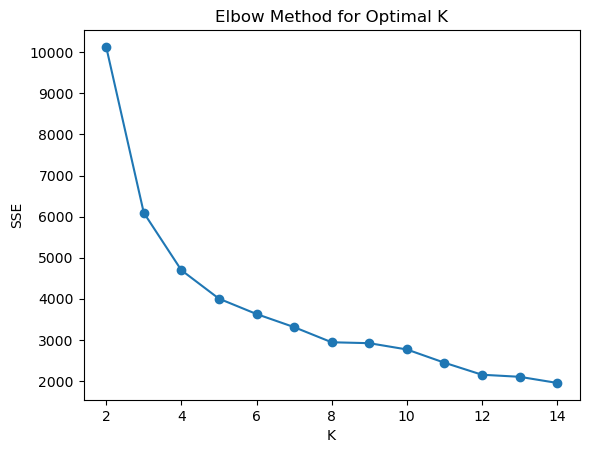

Elbow detected at K = 5


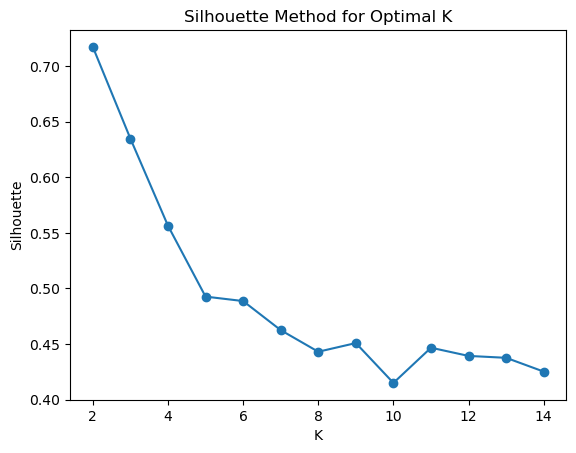

In [27]:
sse_values = []
silhouette_values = []
for k in range(2,15):

    print('************************************************\n')
    kmeans = KMeans(featuresCol="features_scaled", k=k)
    model = kmeans.fit(clusteringData)
    evaluator = ClusteringEvaluator(featuresCol="features_scaled")
    predictions = model.transform(clusteringData)
    silhouette = evaluator.evaluate(predictions)
    sse = model.summary.trainingCost
    
    print(f"Results for K = {k}")
    print(f"Silhouette with squared euclidean distance: {silhouette:.4f}")
    print(f"SSE (Sum of Squared Errors): {sse}")
    sse_values.append(sse)
    silhouette_values.append(silhouette)

# Plot SSE per valutare l'elbow
plt.figure()
plt.plot(range(2, 15), sse_values, marker='o')
plt.xlabel("K")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal K")
plt.show()

# Trova l'elbow con KneeLocator
kl = KneeLocator(range(2, 15), sse_values, curve="convex", direction="decreasing")
print(f"Elbow detected at K = {kl.elbow}")

plt.figure()
plt.plot(range(2, 15), silhouette_values, marker='o')
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.title("Silhouette Method for Optimal K")
plt.show()

### K=5

### 2_ Severity

Silhouette  = 0.6257493112972469

SSE  = 453.0457473938783


Contingency Table:


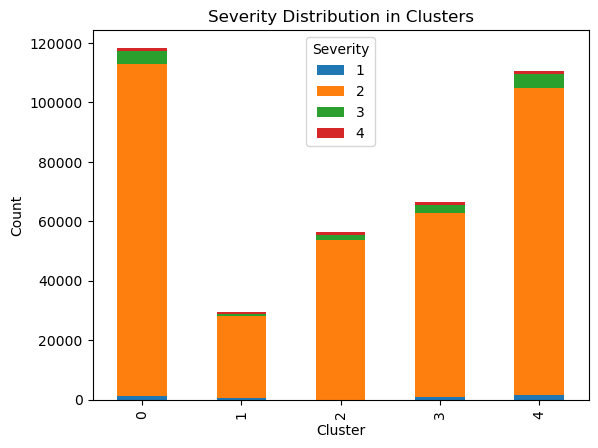

In [33]:
clusteringData = output_dataset.select("features_scaled", "Severity")

kmeans = KMeans(featuresCol="features_scaled").setK(5) 
model = kmeans.fit(clusteringData)
predictions = model.transform(clusteringData)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Severity').count().toPandas() 
pivot_table = contingency_table.pivot(index='prediction', columns='Severity', values='count')

print("Contingency Table:")
# print(pivot_table)

pivot_table.plot(kind='bar', stacked=True, title='Severity Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

### 2_ Working_Weekend

Silhouette  = 0.6257493112972469

SSE  = 453.0457473938783


Contingency Table:
Working_Weekend  Weekend  WorkingDay
prediction                          
0                  28281       90074
1                   5565       23816
2                  12637       43809
3                  15066       51608
4                  26167       84414


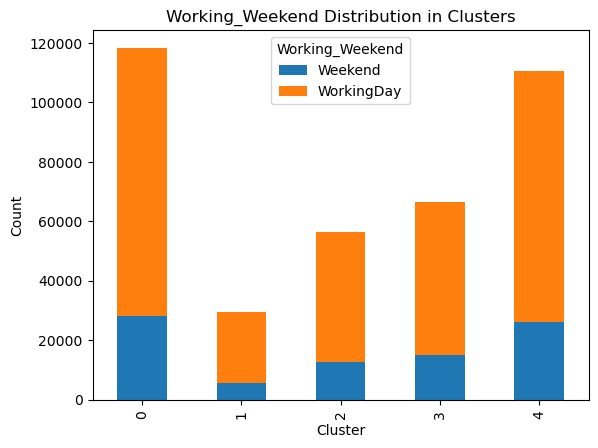

In [35]:
clusteringData = output_dataset.select("features_scaled", "Working_Weekend")

kmeans = KMeans(featuresCol="features_scaled").setK(5)
model = kmeans.fit(clusteringData)
predictions = model.transform(clusteringData)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Working_Weekend').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Working_Weekend', values='count')

print("Contingency Table:")
print(pivot_table)

pivot_table.plot(kind='bar', stacked=True, title='Working_Weekend Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

### 2_ Weather_Condition

Silhouette  = 0.6257493112972469

SSE  = 453.0457473938784


Contingency Table:
Weather_Condition   Cloudy   Foggy   Normal    Rain    Snow
prediction                                                 
0                  37646.0  4476.0  66959.0  9202.0    72.0
1                   2169.0   562.0  26585.0    65.0     NaN
2                  14840.0  5151.0  28855.0  4280.0  3320.0
3                   6094.0  1086.0  59251.0   243.0     NaN
4                  25145.0  2804.0  81733.0   899.0     NaN


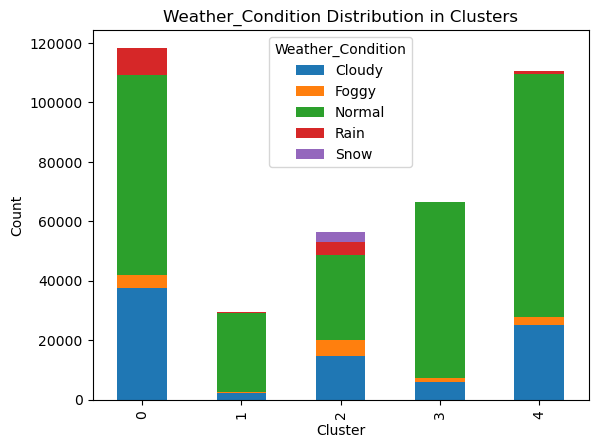

In [36]:
clusteringData = output_dataset.select("features_scaled", "Weather_Condition")

kmeans = KMeans(featuresCol="features_scaled").setK(5)
model = kmeans.fit(clusteringData)
predictions = model.transform(clusteringData)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Weather_Condition').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Weather_Condition', values='count')

print("Contingency Table:")
print(pivot_table)

pivot_table.plot(kind='bar', stacked=True, title='Weather_Condition Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

### 2_ Astronomical_Twilight

Silhouette  = 0.6257493112972469

SSE  = 453.0457473938783


Contingency Table:
Astronomical_Twilight    Day  Night
prediction                         
0                      88247  30108
1                      28913    468
2                      36569  19877
3                      62861   3813
4                      96466  14115


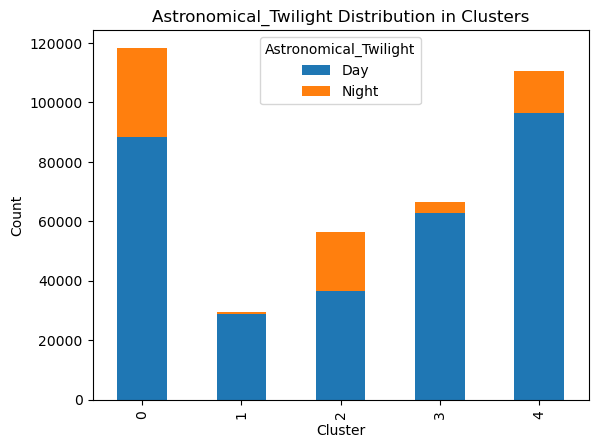

In [37]:
clusteringData = output_dataset.select("features_scaled", "Astronomical_Twilight")

kmeans = KMeans(featuresCol="features_scaled").setK(5)
model = kmeans.fit(clusteringData)
predictions = model.transform(clusteringData)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Astronomical_Twilight').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Astronomical_Twilight', values='count')

print("Contingency Table:")
print(pivot_table)

pivot_table.plot(kind='bar', stacked=True, title='Astronomical_Twilight Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

Silhouette  = 0.6666000402176813

SSE  = 897.9563657978548


Contingency Table:
Astronomical_Twilight     Day  Night
prediction                          
0                      161871  32222
1                       85662   3768
2                       65523  32391


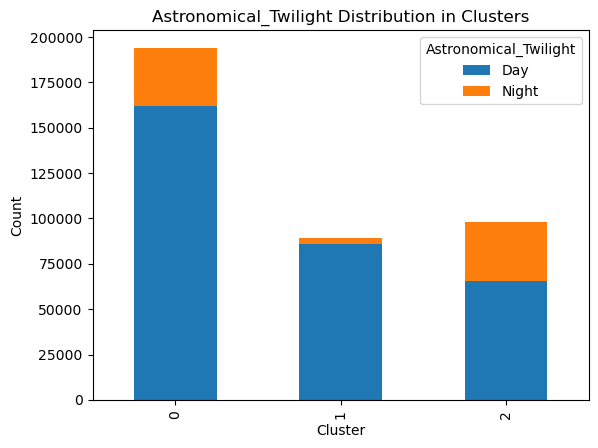

In [39]:
#E' una provaaAAAA

# tentato di forzare il nuemro di cluster
clusteringData = output_dataset.select("features_scaled", "Astronomical_Twilight")

kmeans = KMeans(featuresCol="features_scaled").setK(3)
model = kmeans.fit(clusteringData)
predictions = model.transform(clusteringData)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Astronomical_Twilight').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Astronomical_Twilight', values='count')

print("Contingency Table:")
print(pivot_table)

pivot_table.plot(kind='bar', stacked=True, title='Astronomical_Twilight Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

### 2_ b PROVO ALTRA combinazione di attr continui

In [40]:
#col = ['Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']
col = ['Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Precipitation_in']# solo 2

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster)

scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")

output_dataset = scaler.fit(output_dataset).transform(output_dataset)

In [ ]:
clusteringData = output_dataset.select("features_scaled")

************************************************



Results for K = 2
Silhouette with squared euclidean distance: 0.6811
SSE (Sum of Squared Errors): 1626.9753448661352
************************************************



Results for K = 3
Silhouette with squared euclidean distance: 0.6666
SSE (Sum of Squared Errors): 897.9563657978549
************************************************



Results for K = 4
Silhouette with squared euclidean distance: 0.6473
SSE (Sum of Squared Errors): 591.6619680086967
************************************************



Results for K = 5
Silhouette with squared euclidean distance: 0.6257
SSE (Sum of Squared Errors): 453.04574739387834
************************************************



Results for K = 6
Silhouette with squared euclidean distance: 0.6138
SSE (Sum of Squared Errors): 354.059940443234
************************************************



Results for K = 7
Silhouette with squared euclidean distance: 0.6094
SSE (Sum of Squared Errors): 310.076810463408
************************************************



Results for K = 8
Silhouette with squared euclidean distance: 0.5895
SSE (Sum of Squared Errors): 265.89434034185126
************************************************



Results for K = 9
Silhouette with squared euclidean distance: 0.6556
SSE (Sum of Squared Errors): 189.53822161496234
************************************************



Results for K = 10
Silhouette with squared euclidean distance: 0.6515
SSE (Sum of Squared Errors): 159.02035464568954
************************************************



Results for K = 11
Silhouette with squared euclidean distance: 0.6644
SSE (Sum of Squared Errors): 145.44767404569671
************************************************



Results for K = 12
Silhouette with squared euclidean distance: 0.6496
SSE (Sum of Squared Errors): 124.26288724331015
************************************************



Results for K = 13
Silhouette with squared euclidean distance: 0.6465
SSE (Sum of Squared Errors): 115.43815269034023
************************************************



Results for K = 14
Silhouette with squared euclidean distance: 0.6440
SSE (Sum of Squared Errors): 105.50657534551016


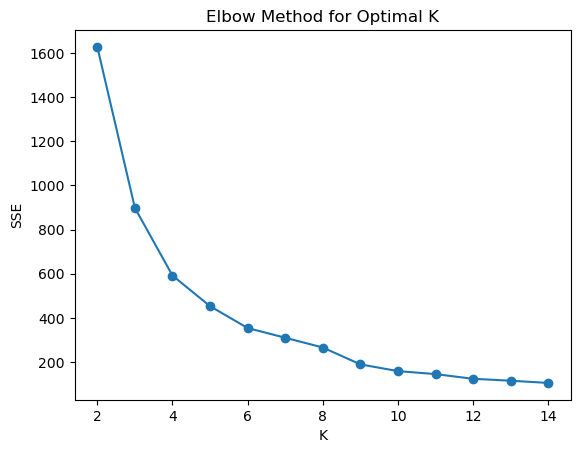

Elbow detected at K = 5


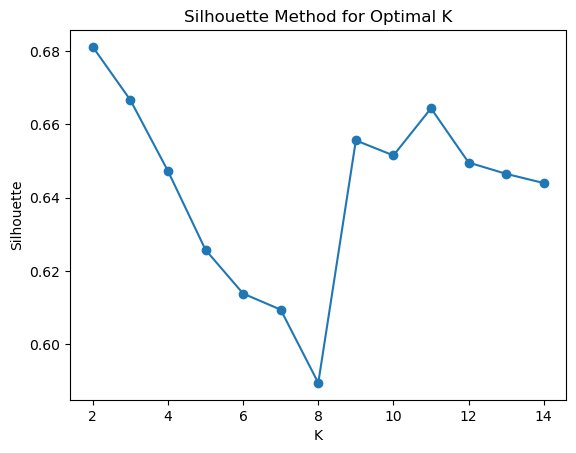

In [41]:
sse_values = []
silhouette_values = []
for k in range(2,15):

    print('************************************************\n')
    kmeans = KMeans(featuresCol="features_scaled", k=k)
    model = kmeans.fit(clusteringData)
    evaluator = ClusteringEvaluator(featuresCol="features_scaled")
    predictions = model.transform(clusteringData)
    silhouette = evaluator.evaluate(predictions)
    sse = model.summary.trainingCost
    
    print(f"Results for K = {k}")
    print(f"Silhouette with squared euclidean distance: {silhouette:.4f}")
    print(f"SSE (Sum of Squared Errors): {sse}")
    sse_values.append(sse)
    silhouette_values.append(silhouette)

# Plot SSE per valutare l'elbow
plt.figure()
plt.plot(range(2, 15), sse_values, marker='o')
plt.xlabel("K")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal K")
plt.show()

# Trova l'elbow con KneeLocator
kl = KneeLocator(range(2, 15), sse_values, curve="convex", direction="decreasing")
print(f"Elbow detected at K = {kl.elbow}")

plt.figure()
plt.plot(range(2, 15), silhouette_values, marker='o')
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.title("Silhouette Method for Optimal K")
plt.show()

 5 o addirittura 9 

### 2_b Severity

Silhouette  = 0.48255390122645586

SSE  = 2444.744600510859


Contingency Table:


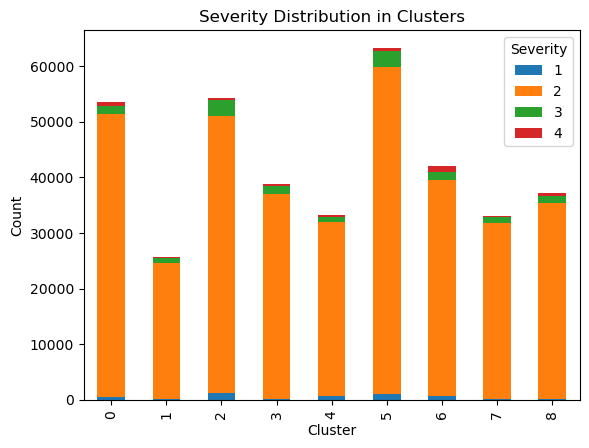

In [42]:
clusteringData = output_dataset.select("features_scaled", "Severity")

kmeans = KMeans(featuresCol="features_scaled").setK(9) 
model = kmeans.fit(clusteringData)
predictions = model.transform(clusteringData)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Severity').count().toPandas() 
pivot_table = contingency_table.pivot(index='prediction', columns='Severity', values='count')

print("Contingency Table:")
# print(pivot_table)

pivot_table.plot(kind='bar', stacked=True, title='Severity Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

### 2_b Astronomical_Twilight

Silhouette  = 0.48255390122645586

SSE  = 2444.7446005108586


Contingency Table:
Astronomical_Twilight    Day  Night
prediction                         
0                      34578  19024
1                      23975   1735
2                      39613  14708
3                      32321   6460
4                      32424    891
5                      56211   7077
6                      39259   2772
7                      28858   4254
8                      25817  11460


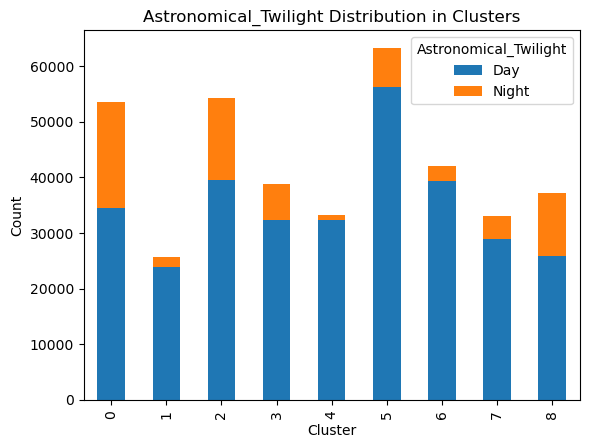

In [43]:
clusteringData = output_dataset.select("features_scaled", "Astronomical_Twilight")

kmeans = KMeans(featuresCol="features_scaled").setK(9)
model = kmeans.fit(clusteringData)
predictions = model.transform(clusteringData)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Astronomical_Twilight').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Astronomical_Twilight', values='count')

print("Contingency Table:")
print(pivot_table)

pivot_table.plot(kind='bar', stacked=True, title='Astronomical_Twilight Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

### 2_b Weather_Condition

Silhouette  = 0.48255390122645586

SSE  = 2444.7446005108586


Contingency Table:
Weather_Condition   Cloudy   Foggy   Normal     Rain    Snow
prediction                                                  
0                  18190.0  6932.0  15496.0  10193.0  2791.0
1                   1474.0   126.0  24101.0      9.0     NaN
2                  24021.0  2254.0  25829.0   2217.0     NaN
3                   7302.0   626.0  30663.0    170.0    20.0
4                   2261.0   767.0  30268.0     19.0     NaN
5                  14359.0  1245.0  47186.0    498.0     NaN
6                   3748.0   631.0  37550.0    102.0     NaN
7                   3442.0   334.0  29311.0     24.0     1.0
8                  11097.0  1164.0  22979.0   1457.0   580.0


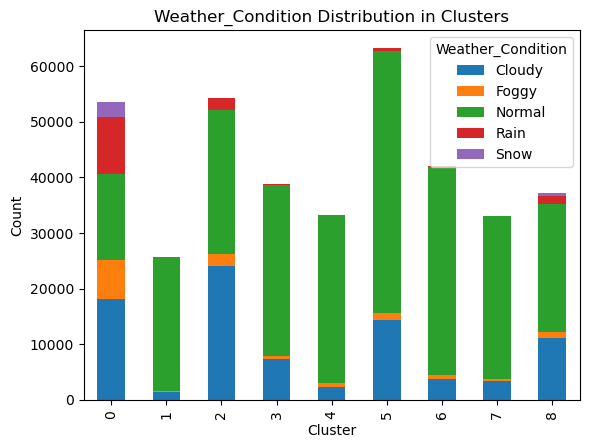

In [44]:
clusteringData = output_dataset.select("features_scaled", "Weather_Condition")

kmeans = KMeans(featuresCol="features_scaled").setK(9)
model = kmeans.fit(clusteringData)
predictions = model.transform(clusteringData)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Weather_Condition').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Weather_Condition', values='count')

print("Contingency Table:")
print(pivot_table)

pivot_table.plot(kind='bar', stacked=True, title='Weather_Condition Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

### 3_b TUTTE incluso il lat e long

In [11]:
col = ['Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in','Start_Lat','Start_Lng']# TUTTE

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster)

scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")

output_dataset = scaler.fit(output_dataset).transform(output_dataset)

#clusteringData.show(truncate=False)

In [12]:
#clusteringData = output_dataset.select("features_scaled", "Severity")
clusteringData = output_dataset.select("features_scaled")

************************************************



Results for K = 2
Silhouette with squared euclidean distance: 0.5432
SSE (Sum of Squared Errors): 38035.21448154602
************************************************



Results for K = 3
Silhouette with squared euclidean distance: 0.5385
SSE (Sum of Squared Errors): 27249.132035317514
************************************************



Results for K = 4
Silhouette with squared euclidean distance: 0.5528
SSE (Sum of Squared Errors): 19651.64098983476
************************************************



Results for K = 5
Silhouette with squared euclidean distance: 0.5952
SSE (Sum of Squared Errors): 14559.124486540639
************************************************



Results for K = 6
Silhouette with squared euclidean distance: 0.5655
SSE (Sum of Squared Errors): 12995.28106433394
************************************************



Results for K = 7
Silhouette with squared euclidean distance: 0.5256
SSE (Sum of Squared Errors): 11166.003302056435
************************************************



Results for K = 8
Silhouette with squared euclidean distance: 0.4739
SSE (Sum of Squared Errors): 10456.456060192211
************************************************



Results for K = 9
Silhouette with squared euclidean distance: 0.5670
SSE (Sum of Squared Errors): 10719.400638466923


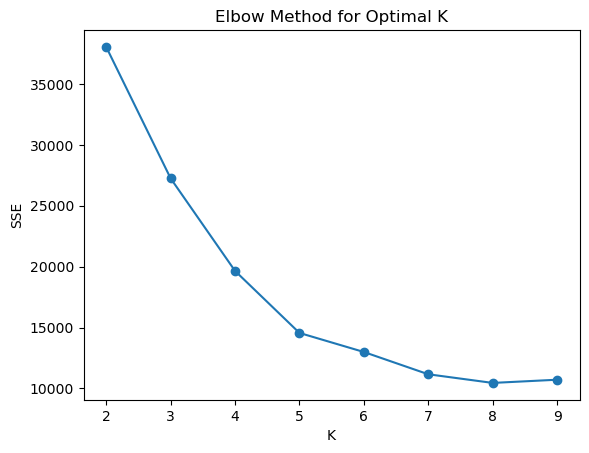

Elbow detected at K = 5


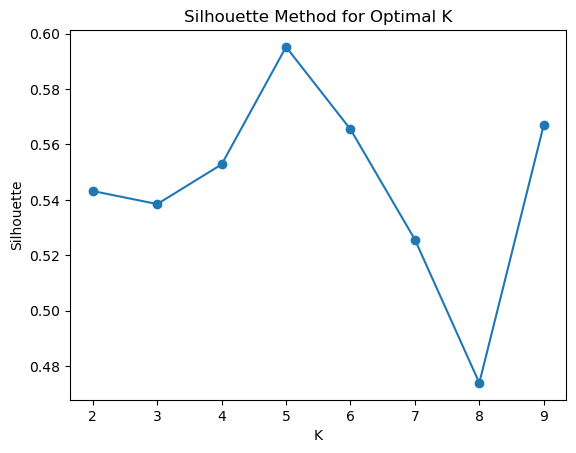

In [13]:
sse_values = []
silhouette_values = []
for k in range(2,10):

    print('************************************************\n')
    kmeans = KMeans(featuresCol="features_scaled", k=k)
    model = kmeans.fit(clusteringData)
    evaluator = ClusteringEvaluator(featuresCol="features_scaled")
    predictions = model.transform(clusteringData)
    silhouette = evaluator.evaluate(predictions)
    sse = model.summary.trainingCost
    
    print(f"Results for K = {k}")
    print(f"Silhouette with squared euclidean distance: {silhouette:.4f}")
    print(f"SSE (Sum of Squared Errors): {sse}")
    sse_values.append(sse)
    silhouette_values.append(silhouette)

# Plot SSE per valutare l'elbow
plt.figure()
plt.plot(range(2, 10), sse_values, marker='o')
plt.xlabel("K")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal K")
plt.show()

# Trova l'elbow con KneeLocator
kl = KneeLocator(range(2, 10), sse_values, curve="convex", direction="decreasing")
print(f"Elbow detected at K = {kl.elbow}")

plt.figure()
plt.plot(range(2, 10), silhouette_values, marker='o')
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.title("Silhouette Method for Optimal K")
plt.show()

### 3_ Weather_Condition

Silhouette  = 0.5952140752777428

SSE  = 14559.124486540635


Contingency Table:
Weather_Condition   Cloudy   Foggy   Normal    Rain    Snow
prediction                                                 
0                  34567.0  4884.0  69385.0  4898.0    61.0
1                  15169.0  1758.0  13877.0  4230.0  2203.0
2                   6969.0   663.0  59985.0    56.0     NaN
3                  21922.0  5362.0  40052.0  5334.0  1127.0
4                   7267.0  1412.0  80084.0   171.0     1.0


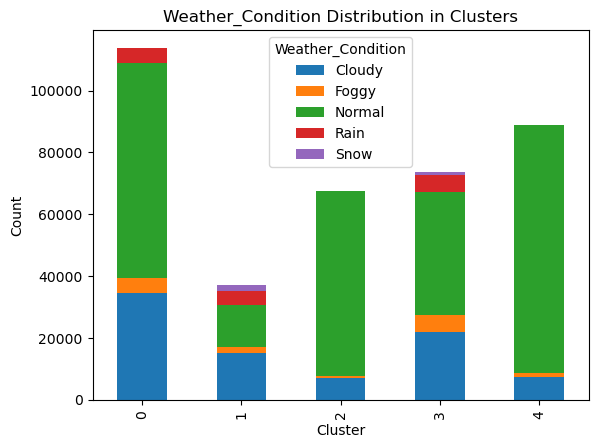

In [15]:
clusteringData = output_dataset.select("features_scaled", "Weather_Condition")

kmeans = KMeans(featuresCol="features_scaled").setK(5)
model = kmeans.fit(clusteringData)
predictions = model.transform(clusteringData)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Weather_Condition').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Weather_Condition', values='count')

print("Contingency Table:")
print(pivot_table)

pivot_table.plot(kind='bar', stacked=True, title='Weather_Condition Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

### 3_ Severity

Silhouette  = 0.5952140752777428

SSE  = 14559.124486540637


Contingency Table:


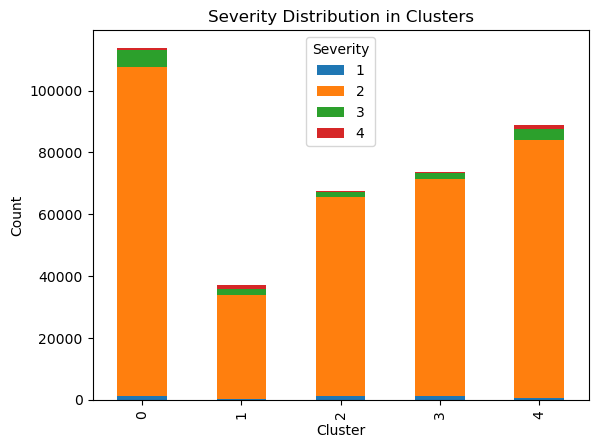

In [17]:
clusteringData = output_dataset.select("features_scaled", "Severity")

kmeans = KMeans(featuresCol="features_scaled").setK(5) 
model = kmeans.fit(clusteringData)
predictions = model.transform(clusteringData)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Severity').count().toPandas() 
pivot_table = contingency_table.pivot(index='prediction', columns='Severity', values='count')

print("Contingency Table:")
# print(pivot_table)

pivot_table.plot(kind='bar', stacked=True, title='Severity Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

### BISEKTING

In [17]:
from pyspark.mllib.clustering import BisectingKMeans as BM
from pyspark.mllib.clustering import BisectingKMeansModel
from pyspark.ml.clustering import BisectingKMeans
!pip install kneed
from kneed import KneeLocator
import matplotlib.pyplot as plt


### TUTTE LE CONTINUE

In [24]:
df_cluster_bisecting=df

In [23]:
col = ['Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster_bisecting)

scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")

output_dataset = scaler.fit(output_dataset).transform(output_dataset)

In [25]:
clusteringData_bisecting=output_dataset.select("features_scaled") 

************************************************



Results for K = 2
Silhouette with squared euclidean distance: 0.7171
SSE (Sum of Squared Errors): 10130.895100324735
************************************************



Results for K = 3
Silhouette with squared euclidean distance: 0.5364
SSE (Sum of Squared Errors): 7321.160470217263
************************************************



Results for K = 4
Silhouette with squared euclidean distance: 0.5546
SSE (Sum of Squared Errors): 4700.741758450895
************************************************



Results for K = 5
Silhouette with squared euclidean distance: 0.4917
SSE (Sum of Squared Errors): 4359.511868430807
************************************************



Results for K = 6
Silhouette with squared euclidean distance: 0.4559
SSE (Sum of Squared Errors): 3915.7221901027333
************************************************



Results for K = 7
Silhouette with squared euclidean distance: 0.4274
SSE (Sum of Squared Errors): 3544.9708394349764
************************************************



Results for K = 8
Silhouette with squared euclidean distance: 0.4104
SSE (Sum of Squared Errors): 3141.066460073027
************************************************



Results for K = 9
Silhouette with squared euclidean distance: 0.3650
SSE (Sum of Squared Errors): 2912.5162333561566
************************************************



Results for K = 10
Silhouette with squared euclidean distance: 0.3579
SSE (Sum of Squared Errors): 2756.5360272050675
************************************************



Results for K = 11
Silhouette with squared euclidean distance: 0.3442
SSE (Sum of Squared Errors): 2568.801399262793
************************************************



Results for K = 12
Silhouette with squared euclidean distance: 0.3606
SSE (Sum of Squared Errors): 2430.4791608245596
************************************************



Results for K = 13
Silhouette with squared euclidean distance: 0.3637
SSE (Sum of Squared Errors): 2295.1478708787054
************************************************



Results for K = 14
Silhouette with squared euclidean distance: 0.3724
SSE (Sum of Squared Errors): 2098.201245290462
************************************************



Results for K = 15
Silhouette with squared euclidean distance: 0.3829
SSE (Sum of Squared Errors): 1946.7038947526253
************************************************



Results for K = 16
Silhouette with squared euclidean distance: 0.3922
SSE (Sum of Squared Errors): 1818.0488103268744
************************************************



Results for K = 17
Silhouette with squared euclidean distance: 0.3551
SSE (Sum of Squared Errors): 1786.5084010024748
************************************************



Results for K = 18
Silhouette with squared euclidean distance: 0.3426
SSE (Sum of Squared Errors): 1757.3287687127158
************************************************



Results for K = 19
Silhouette with squared euclidean distance: 0.3255
SSE (Sum of Squared Errors): 1722.523131384478
************************************************



Results for K = 20
Silhouette with squared euclidean distance: 0.3163
SSE (Sum of Squared Errors): 1697.6620740392373
************************************************



Results for K = 21
Silhouette with squared euclidean distance: 0.3173
SSE (Sum of Squared Errors): 1654.8921625995667
************************************************



Results for K = 22
Silhouette with squared euclidean distance: 0.2994
SSE (Sum of Squared Errors): 1648.065892682031
************************************************



Results for K = 23
Silhouette with squared euclidean distance: 0.2957
SSE (Sum of Squared Errors): 1618.37333837726
************************************************



Results for K = 24
Silhouette with squared euclidean distance: 0.2949
SSE (Sum of Squared Errors): 1583.3248311057114
************************************************



Results for K = 25
Silhouette with squared euclidean distance: 0.2778
SSE (Sum of Squared Errors): 1557.7037114750628
************************************************



Results for K = 26
Silhouette with squared euclidean distance: 0.2859
SSE (Sum of Squared Errors): 1492.3208189851143
************************************************



Results for K = 27
Silhouette with squared euclidean distance: 0.2929
SSE (Sum of Squared Errors): 1475.3811182291593
************************************************



Results for K = 28
Silhouette with squared euclidean distance: 0.2936
SSE (Sum of Squared Errors): 1444.5016165935558
************************************************



Results for K = 29
Silhouette with squared euclidean distance: 0.2901
SSE (Sum of Squared Errors): 1395.4258171894926


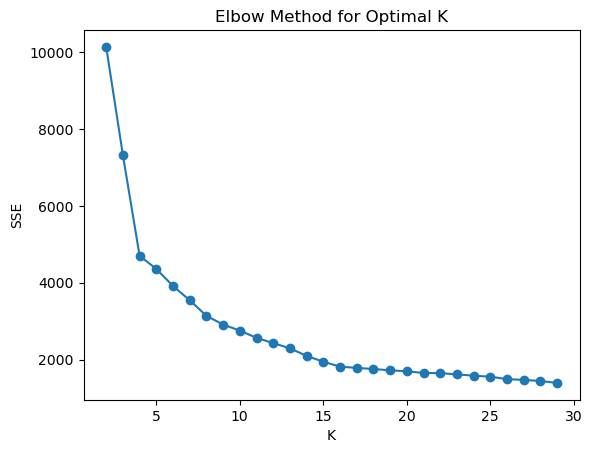

Elbow detected at K = 8


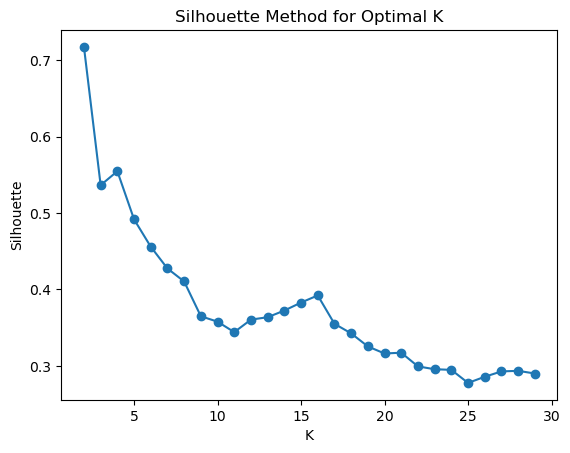

In [26]:
sse_values = []
silhouette_values = []
for k in range(2,30): ####### 30 !!!!!!!!!!!!!!!!!!!!!!!!111111

    print('************************************************\n')

    bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=k)
    model = bisect_kmeans.fit(clusteringData_bisecting)
    
    evaluator = ClusteringEvaluator(featuresCol="features_scaled")
    predictions = model.transform(clusteringData_bisecting)
    silhouette = evaluator.evaluate(predictions)
    sse = model.summary.trainingCost
    
    print(f"Results for K = {k}")
    print(f"Silhouette with squared euclidean distance: {silhouette:.4f}")
    print(f"SSE (Sum of Squared Errors): {sse}")
    sse_values.append(sse)
    silhouette_values.append(silhouette)

# Plot SSE per valutare l'elbow
plt.figure()
plt.plot(range(2, 30), sse_values, marker='o')
plt.xlabel("K")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal K")
plt.show()

# Trova l'elbow con KneeLocator
kl = KneeLocator(range(2, 30), sse_values, curve="convex", direction="decreasing")
print(f"Elbow detected at K = {kl.elbow}")

plt.figure()
plt.plot(range(2, 30), silhouette_values, marker='o')
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.title("Silhouette Method for Optimal K")
plt.show()

con Tutti gli attributi continui il miglior K risulta essere K = 8

#### 1_Severity

Silhouette  = 0.41042689561451806

SSE  = 3141.066460073027


Contingency Table:


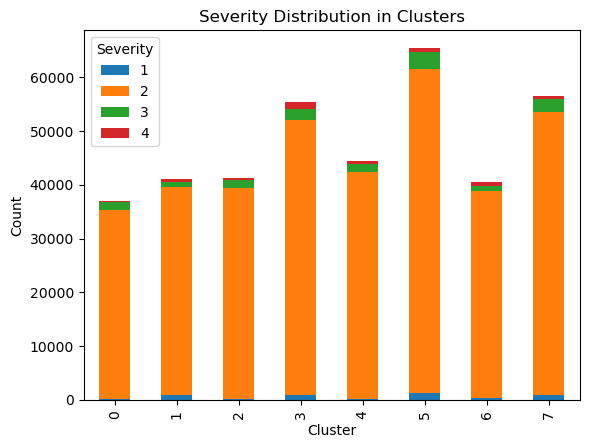

In [27]:
clusteringData_bisecting = output_dataset.select("features_scaled", "Severity")


bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=8) # K=
model = bisect_kmeans.fit(clusteringData_bisecting)
predictions = model.transform(clusteringData_bisecting)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Severity').count().toPandas() 
pivot_table = contingency_table.pivot(index='prediction', columns='Severity', values='count')

print("Contingency Table:")
# print(pivot_table)

pivot_table.plot(kind='bar', stacked=True, title='Severity Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

#### 1_Weather_Condition

Silhouette  = 0.41042689561451806

SSE  = 3141.066460073027


Contingency Table:


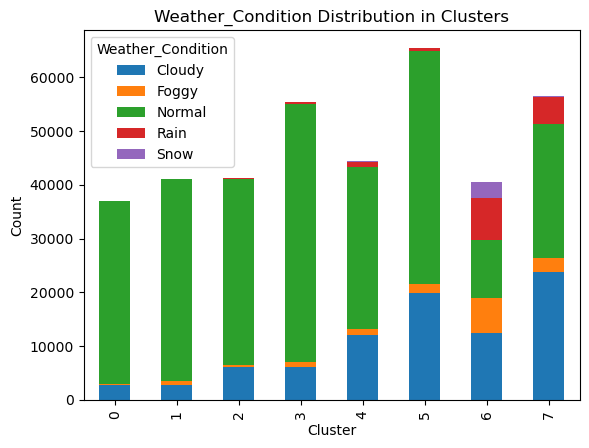

In [28]:
clusteringData_bisecting = output_dataset.select("features_scaled", "Weather_Condition")


bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=8) # K=
model = bisect_kmeans.fit(clusteringData_bisecting)
predictions = model.transform(clusteringData_bisecting)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Weather_Condition').count().toPandas() 
pivot_table = contingency_table.pivot(index='prediction', columns='Weather_Condition', values='count')

print("Contingency Table:")
# print(pivot_table)

pivot_table.plot(kind='bar', stacked=True, title='Weather_Condition Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

### 1_ season 

Silhouette  = 0.41042689561451806

SSE  = 3141.066460073027


Contingency Table:


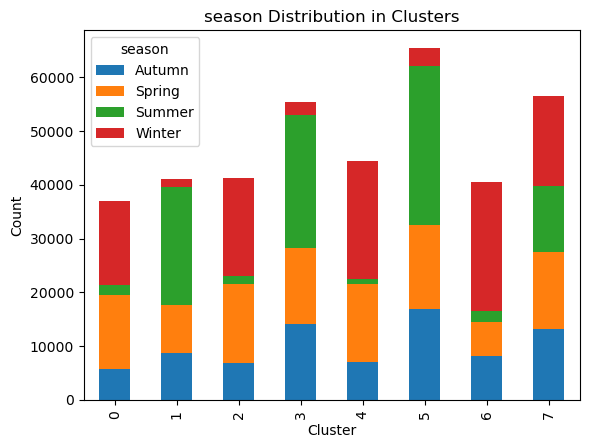

In [29]:
clusteringData_bisecting = output_dataset.select("features_scaled", "season")


bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=8) # K=
model = bisect_kmeans.fit(clusteringData_bisecting)
predictions = model.transform(clusteringData_bisecting)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'season').count().toPandas() 
pivot_table = contingency_table.pivot(index='prediction', columns='season', values='count')

print("Contingency Table:")
# print(pivot_table)

pivot_table.plot(kind='bar', stacked=True, title='season Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

#### 1_working Weekend 

Silhouette  = 0.41042689561451806

SSE  = 3141.066460073027


Contingency Table:


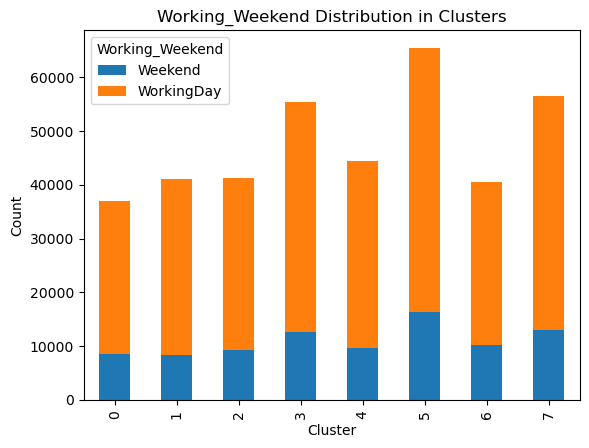

In [30]:
clusteringData_bisecting = output_dataset.select("features_scaled", "Working_Weekend")


bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=8) # K=
model = bisect_kmeans.fit(clusteringData_bisecting)
predictions = model.transform(clusteringData_bisecting)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Working_Weekend').count().toPandas() 
pivot_table = contingency_table.pivot(index='prediction', columns='Working_Weekend', values='count')

print("Contingency Table:")
# print(pivot_table)

pivot_table.plot(kind='bar', stacked=True, title='Working_Weekend Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

#### 1- hour 

Silhouette  = 0.41042689561451806

SSE  = 3141.066460073027


Contingency Table:


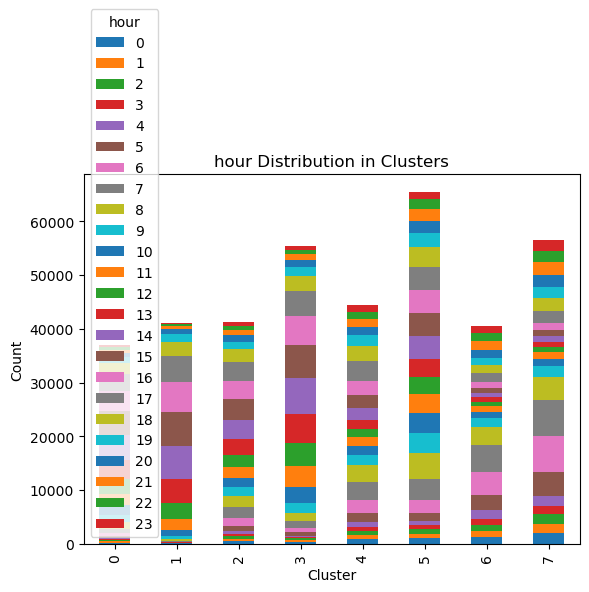

In [31]:
clusteringData_bisecting = output_dataset.select("features_scaled", "hour")


bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=8) # K=
model = bisect_kmeans.fit(clusteringData_bisecting)
predictions = model.transform(clusteringData_bisecting)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'hour').count().toPandas() 
pivot_table = contingency_table.pivot(index='prediction', columns='hour', values='count')

print("Contingency Table:")
# print(pivot_table)

pivot_table.plot(kind='bar', stacked=True, title='hour Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

#### 1_ day of the week

Silhouette  = 0.41042689561451806

SSE  = 3141.066460073027


Contingency Table:


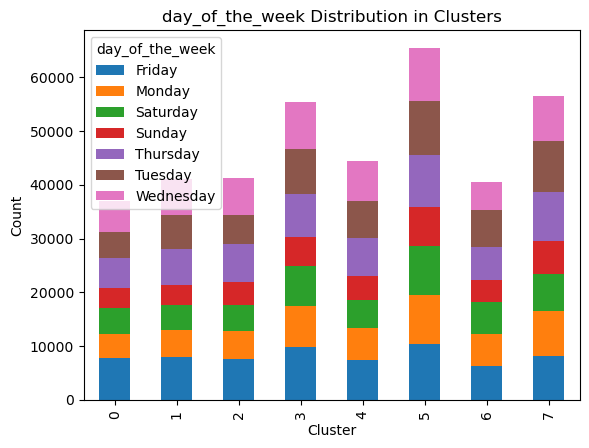

In [32]:
clusteringData_bisecting = output_dataset.select("features_scaled", "day_of_the_week")


bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=8) # K=
model = bisect_kmeans.fit(clusteringData_bisecting)
predictions = model.transform(clusteringData_bisecting)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'day_of_the_week').count().toPandas() 
pivot_table = contingency_table.pivot(index='prediction', columns='day_of_the_week', values='count')

print("Contingency Table:")
# print(pivot_table)

pivot_table.plot(kind='bar', stacked=True, title='day_of_the_week Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

### Astronomical_Twilight 

Silhouette  = 0.41042689561451806

SSE  = 3141.066460073027


Contingency Table:


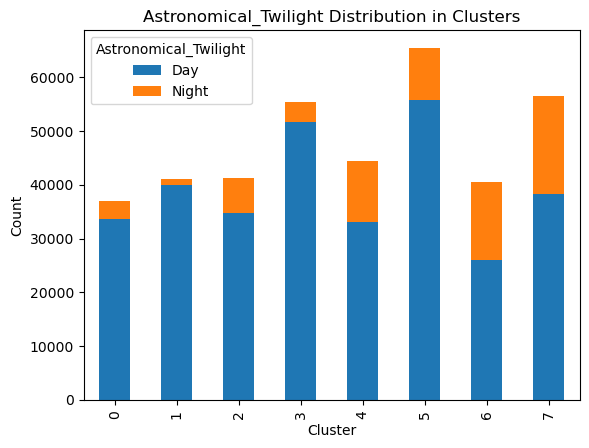

In [33]:
clusteringData_bisecting = output_dataset.select("features_scaled", "Astronomical_Twilight")


bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=8) # K=
model = bisect_kmeans.fit(clusteringData_bisecting)
predictions = model.transform(clusteringData_bisecting)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Astronomical_Twilight').count().toPandas() 
pivot_table = contingency_table.pivot(index='prediction', columns='Astronomical_Twilight', values='count')

print("Contingency Table:")
# print(pivot_table)

pivot_table.plot(kind='bar', stacked=True, title='Astronomical_Twilight Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

## K_modes

### installo e importo K-modes

In [3]:
!pip install .
# 
### credo che la prima volta che si-ri usa il notebook va fatto girare, poi obbligatorio fare il restart del kernel

Processing /home/jovyan/Progetto 
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark-kmodes: filename=pyspark_kmodes-0.1.0-py2.py3-none-any.whl size=12669 sha256=7c1babc54c71e425e2ad180c635eb31e93f305450940d191ec15e2c266ecb7a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-p9ie3sai/wheels/ee/0d/59/db92f66c210e1ad986f54f83e4030fea848989d73b90fd7540
Successfully built pyspark-kmodes


In [4]:
from pyspark_kmodes import *

In [5]:
from pyspark.sql.functions import monotonically_increasing_id

In [6]:
df_with_row_id = df.withColumn("row_id", monotonically_increasing_id())

In [7]:
df_kmodes_id= df_with_row_id.select('row_id','City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout',
                     'Station','Stop','Traffic_Calming','Traffic_Signal','hour','month','season','Weather_Condition','Astronomical_Twilight','Working_Weekend','Severity')



In [8]:
df_kmodes= df.select('City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout',
                     'Station','Stop','Traffic_Calming','Traffic_Signal','hour','month','season','Weather_Condition','Working_Weekend','Astronomical_Twilight',
                     'Severity')

### Severity

In [9]:
df_kmodes_id= df_with_row_id.select('row_id','City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout',
                     'Station','Stop','Traffic_Calming','Traffic_Signal','month','season','Weather_Condition','Severity','Astronomical_Twilight')

df_kmodes= df.select('City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout',
                     'Station','Stop','Traffic_Calming','Traffic_Signal','month','season','Weather_Condition','Severity','Astronomical_Twilight')

In [10]:
df_kmodes_severity=df_kmodes.drop('Severity')

In [11]:
df_kmodes_rdd=df_kmodes_severity.rdd

stampiamo la lista dei costi per salvare i costi, per poi printarli e fare il detect con il knee locaotor della k migliore. 

In [12]:
lista_costi=[]
for k in range(2,11):
    n_clusters = k
    max_iter = 10
    method = EnsembleKModes(n_clusters, max_iter)
    model = method.fit(df_kmodes_rdd)
    lista_costi.append(method.mean_cost)

Iteration  0


TypeError: slice indices must be integers or None or have an __index__ method

se crash-a e mi tocca ri farlo a mano, continuto con il k al quale si è fermato e appendo il costo nella lista costi 

In [14]:
n_clusters = 3
max_iter = 10

method = EnsembleKModes(n_clusters, max_iter)

In [15]:
model = method.fit(df_kmodes_rdd)

Iteration  0


TypeError: slice indices must be integers or None or have an __index__ method

In [ ]:
lista_costi.append(method.mean_cost)

se non ho avuto problemi ed ho già la lista dei costi posso procede con sotto. 

In [ ]:
!pip install kneed

In [ ]:
from kneed import KneeLocator
plt.figure()
plt.plot(range(2, 11), lista_costi, marker='o')
plt.xlabel("K")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal K")
plt.show()

# Trova l'elbow con KneeLocator
kl = KneeLocator(range(2, 11), lista_costi, curve="convex", direction="decreasing")
print(f"Elbow detected at K = {kl.elbow}")